# CS445: Computational Photography
## Programming Project 4: Image-Based Lighting


## Recovering HDR Radiance Maps 

Load libraries and data

In [260]:
#Name: Justin Garzione
#NetID: justing6
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [261]:
# System imports
from os import path
import math
import random
# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# modify to where you store your project data including utils
datadir = "/Users/justingarzione/Documents/CompPhoto/PROJECT4/proj4_real" 

utilfn = datadir + "utils"
!cp -r "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .

# can change this to your output directory of choice
!mkdir "images"
!mkdir "images/outputs"

# import starter code
import utils
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter



cp: /Users/justingarzione/Documents/CompPhoto/PROJECT4/proj4_realutils: No such file or directory
cp: /Users/justingarzione/Documents/CompPhoto/PROJECT4/proj4_realsamples: No such file or directory
mkdir: images: File exists
mkdir: images/outputs: File exists


### Reading LDR images

You can use the provided samples or your own images.  You get more points for using your own images, but it might help to get things working first with the provided samples.

In [106]:
# TODO: Replace this with your path and files

imdir = 'samples'
imfns = ['0024.jpg', '0060.jpg', '0120.jpg', '0205.jpg', '0553.jpg']
exposure_times = [1/24.0, 1/60.0, 1/120.0, 1/205.0, 1/553.0]

ldr_images = []
for f in np.arange(len(imfns)):
  im = read_image(imdir + '/' + imfns[f])
  if f==0:
    imsize = int((im.shape[0] + im.shape[1])/2) # set width/height of ball images
    ldr_images = np.zeros((len(imfns), imsize, imsize, 3))
  ldr_images[f] = cv2.resize(im, (imsize, imsize))

background_image_file = imdir + '/' + 'empty.jpg'
background_image = read_image(background_image_file)



### Naive LDR merging 

Compute the HDR image as average of irradiance estimates from LDR images

In [136]:
def make_hdr_naive(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) Divide each image by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.
    
    2) Return average of above images
    
    
    For further explanation, please refer to problem page for how to do it.
      
    Args:
        ldr_images(np.ndarray): N x H x W x 3  shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each image.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            naive ldr merging implementation.
        (np.ndarray): N x H x W x 3  shaped numpy array representing log irradiances
            for each exposure
            
    '''
    N, H, W, C = ldr_images.shape
    log_irradiances = np.zeros(ldr_images.shape)
    ldr_images2 = np.copy(ldr_images)
    hdr_image = np.zeros((H,W,C))
    
    # sanity check
    assert N == len(exposures)
  
    # TO DO
    for image in range(0,N):
        ldr_images2[image,:,:,:] = ldr_images[image,:,:,:] + 0.01
        log_irradiances[image,:,:,:] = np.log(ldr_images2[image,:,:,:] / exposures[image])
        hdr_image = hdr_image + (np.exp(log_irradiances[image,:,:,:]))
        
    hdr_image = hdr_image / N
  
    return hdr_image, log_irradiances



In [137]:
def display_hdr_image(im_hdr):
    '''
    Maps the HDR intensities into a 0 to 1 range and then displays. 
    Three suggestions to try: 
      (1) Take log and then linearly map to 0 to 1 range (see display.py for example) 
      (2) img_out = im_hdr / (1 + im_hdr)
      (3) HDR display code in a python package 
    '''
    #H, W, C = im_hdr.shape
    #Don't use this 
    #Reinhard Mapping Function
    #rescaled_image = rescale_images_linear(im_hdr)
    im_hdr = np.log(im_hdr)
    #rescaled_image = im_hdr / (1 + im_hdr)
    rescaled_image = rescale_images_linear(im_hdr)
    #print(rescaled_image)
    print(np.max(rescaled_image))
    print(np.min(rescaled_image))
    plt.imshow(rescaled_image)
    
    
    
    #im_out = im_hdr / (1 + im_hdr)
    #plt.imshow(im_out)


    # TO DO


HDR Image
1.0
0.0


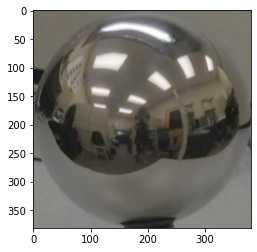

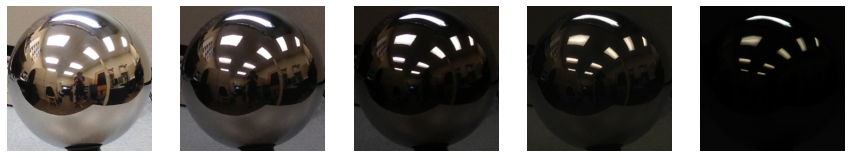

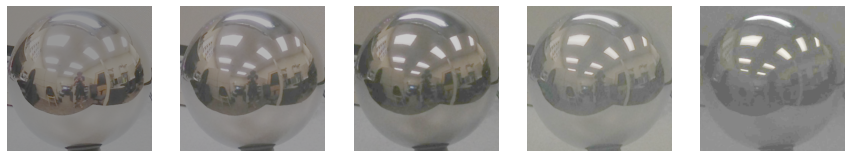

In [138]:

# get HDR image, log irradiance
naive_hdr_image, naive_log_irradiances = make_hdr_naive(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(naive_hdr_image, 'images/outputs/naive_hdr.hdr')

# display HDR image
print('HDR Image')
display_hdr_image(naive_hdr_image)

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(naive_log_irradiances)


### Weighted LDR merging 

Compute HDR image as a weighted average of irradiance estimates from LDR images, where weight is based on pixel intensity so that very low/high intensities get less weight


In [139]:
def make_hdr_weighted(ldr_images: np.ndarray, exposure_times: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    
    The steps to implement:
    1) compute weights for images based on intensities for each exposure
        - This can be a binary mask to exclude low / high intensity values

    2) Divide each image by its exposure time.
        - This will rescale images as if it had been exposed for 1 second.
    
    3) Return weighted average of above images
    
    
    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposure_times(list): list of length N, representing exposures of each image.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged without
            under - over exposed regions

    '''
    N, H, W, C = ldr_images.shape
    ldr_images2 = np.copy(ldr_images)
    weights = np.zeros(ldr_images.shape,dtype='float32')
    total_weights = np.zeros((H,W,C),dtype='float32')
    log_irradiances = np.zeros(ldr_images.shape,dtype='float32')
    hdr_image = np.zeros((H,W,C), dtype='float32')
    w = lambda z: float(.5-abs(z-.5))
    # sanity check
    assert N == len(exposure_times)
    
    print("LDR 1")
    print(np.max(ldr_images[0,:,:,:]))
    print(np.min(ldr_images[0,:,:,:]))
    
    print("LDR 2")
    print(np.max(ldr_images[1,:,:,:]))
    print(np.min(ldr_images[1,:,:,:]))
    
    print("LDR 3")
    print(np.max(ldr_images[2,:,:,:]))
    print(np.min(ldr_images[2,:,:,:]))
    
    print("LDR 4")
    print(np.max(ldr_images[3,:,:,:]))
    print(np.min(ldr_images[3,:,:,:]))
    
    print("LDR 5")
    print(np.max(ldr_images[4,:,:,:]))
    print(np.min(ldr_images[4,:,:,:]))

    #Get the irradiances
    for image in range(N):
        ldr_images2[image,:,:,:] = ldr_images[image,:,:,:] + 0.01
        log_irradiances[image,:,:,:] = np.log(ldr_images2[image,:,:,:] / exposure_times[image])
    
    #Get the Weights
    for x in range(W):
        for y in range(H):
            for channel in range(C):
                for image in range(N):
                    weights[image,y,x,channel] = w(ldr_images[image,y,x,channel])
    
    #Get Total Weights
    for image in range(N):
        total_weights[:,:,:] = total_weights[:,:,:] + weights[image,:,:,:]
    
    #Normalize the Weights
    for image in range(N):
        weights[image,:,:,:] = weights[image,:,:,:] / total_weights[:,:,:]
    
    for image in range(N):
        hdr_image = hdr_image + (np.exp(log_irradiances[image,:,:,:]) * weights[image,:,:,:])
    
    print("Log Irradiances")
    print(np.max(log_irradiances[1,:,:,:]))
    print(np.min(log_irradiances[1,:,:,:]))
    print()
    print("HDR Image")
    print(np.max(hdr_image))
    print(np.min(hdr_image))
    print()
    
    
    return hdr_image
    


LDR 1
1.0
0.0
LDR 2
1.0
7.530516450060531e-05
LDR 3
1.0
0.0
LDR 4
1.0
0.00038553401827812195
LDR 5
1.0
0.0
Log Irradiances
4.104295
-0.5033233

HDR Image
552.1051
1.0920627

1.0
0.0


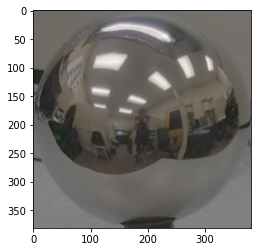

In [140]:
# get HDR image, log irradiance
weighted_hdr_image = make_hdr_weighted(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(weighted_hdr_image, 'images/outputs/weighted_hdr.hdr')

# display HDR image
display_hdr_image(weighted_hdr_image)


Display of difference between naive and weighted for your own inspection

Where does the weighting make a big difference increasing or decreasing the irradiance estimate?  Think about why.

Min ratio =  0.3699526928467504   Max ratio =  2.8600699011598145


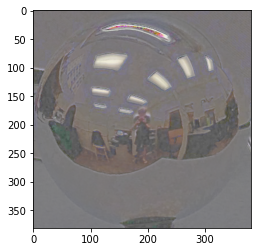

In [141]:
# display difference between naive and weighted 
#log_diff_im = weighted_hdr_image-naive_hdr_image
log_diff_im = np.log(weighted_hdr_image)-np.log(naive_hdr_image)
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

### LDR merging with camera response function estimation 

Compute HDR after calibrating the photometric reponses to obtain more accurate irradiance estimates from each image

Some suggestions on using <tt>gsolve</tt>:
<ul>
	<li>When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (1000 or so can suffice), but make sure all pixel locations are the same for each exposure.</li>
	<li>The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method).</li>
	<li>Try different lambda values for recovering <i>g</i>. Try lambda=1 initially, then solve for <i>g</i> and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.</li>
	<li>Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log irradiance values, so make sure to exponentiate the result and save irradiance in linear scale.</li>
</ul>

In [359]:
def make_hdr_estimation(ldr_images: np.ndarray, exposure_times: list, lm)-> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.
    
    **IMPORTANT**
    The gsolve operations should be ran with:
        Z: int64 array of shape N x P, where N = number of images, P = number of pixels
        B: float32 array of shape N, log shutter times
        l: lambda; float to control amount of smoothing
        w: function that maps from float intensity to weight  
    The steps to implement:
    1) Create random points to sample (from mirror ball region)
    2) For each exposure, compute g values using samples
    3) Recover HDR image using g values
    

    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each image.
            Each exposure should correspond to LDR images' exposure value.
        lm (scalar): the smoothing parameter
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            gsolve
        (np.ndarray): N x H x W x 3 shaped numpy array representing log irradiances
            for each exposure
        (np.ndarray): 3 x 256 shaped numpy array representing g values of each pixel intensity
            in each channel (used for plotting)
    '''
    N, H, W, C = ldr_images.shape
    ldr_images = ldr_images*255
    ldr_images = ldr_images.astype('int64')
    weights = np.zeros(ldr_images.shape,dtype='float32')
    total_weights = np.zeros((H,W,C),dtype='float32')
    log_irradiances = np.zeros((ldr_images.shape),dtype='float32')
    hdr_image = np.zeros((H,W,C), dtype='float32')
    # sanity check
    assert N == len(exposure_times)
    P = 1000
    Z = np.zeros((N,P), dtype='int64')
    B = np.zeros((N), dtype='float32')
    l = 1000
    w = lambda z: float(128-abs(z-128))
    centerX = W / 2
    centerY = H / 2
    R = W / 2
    g2 = np.zeros((C,256))
    le = np.zeros((P,C))
    
    #Make sure sample points are within sphere -> Check if sample point is within radius to center
    #Only sampling once -> not for each channel
    
    # TO DO: implement HDR estimation using gsolve
    for x in range(N):
        B[x] = float(np.log(exposure_times[x]))
    
    for channel in range(0,C):
            for pixel in range(0,P):
                #--Random Coordinates Within Sphere--
                rand = random.uniform(0,1)
                r = R * math.sqrt(rand)
                theta = rand * 2 * math.pi
                x = math.floor(centerX + r * math.cos(theta))
                y = math.floor(centerY + r * math.sin(theta))
                #--End Random Coordinates--
                
                #Use Coordinates to find pixels in ldr -> do for each channel at same coordinate pair
                for image in range(0,N):
                    Z[image,pixel] = ldr_images[image,y,x,channel]
                    
            #Compute G and assign to corresponding G channel        
            g2[channel,:],le[:,channel] = gsolve(Z,B,l,w)
    
    #Test Min and Max for LDR
    print(np.min(ldr_images[:,:,:,:]))
    print(np.max(ldr_images[:,:,:,:]))
    
    #Transform ldr_images into log irradiances images with g function
    for x in range(0,W):
        for y in range(0,H):
            for image in range(0,N):
                for channel in range(0,C):
                    #Get weights use weight lambda function on LDRs
                    weights[image,y,x,channel] = w(ldr_images[image,y,x,channel])
                    #Compute First Part of Equation 6 in Paper by Finding the G Map Values minus log Exposure
                    log_irradiances[image,y,x,channel] = (g2[channel,(ldr_images[image,y,x,channel])] - B[image])
    
    #Get Total Weights
    for image in range(N):
        total_weights[:,:,:] = total_weights[:,:,:] + weights[image,:,:,:]
    
    #Normalize the Weights
    for image in range(N):
        weights[image,:,:,:] = weights[image,:,:,:] / total_weights[:,:,:]
    
    #Build HDR from weighted images -> Sum of weighted, exponentiated, log irradiances
    for image in range(N):
        hdr_image = hdr_image + (np.exp(log_irradiances[image,:,:,:]) * weights[image,:,:,:])
    
    
    #Return HDR, Log Irrad, G with Channels
    return hdr_image,log_irradiances,g2
    

0
255
1.0
0.0


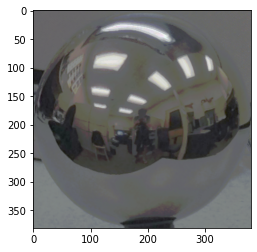

In [360]:
lm = 1000
# get HDR image, log irradiance
calib_hdr_image, calib_log_irradiances, g = make_hdr_estimation(ldr_images, exposure_times, lm)

# write HDR image to directory
write_hdr_image(calib_hdr_image, 'images/outputs/calib_hdr.hdr')

# display HDR image
display_hdr_image(calib_hdr_image)

The following code displays your results. You can copy the resulting images and plots directly into your report where appropriate.

Min ratio =  0.4507998   Max ratio =  4.127394


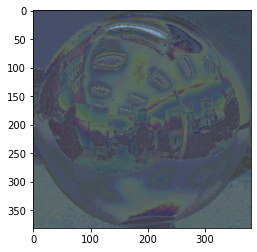

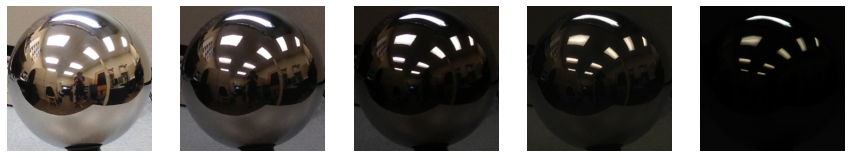

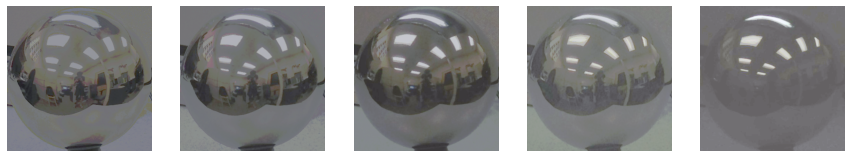

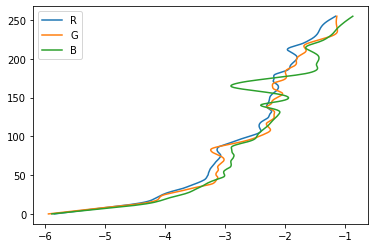

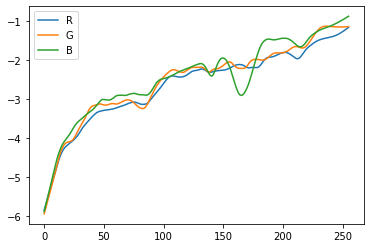

In [361]:
# display difference between calibrated and weighted
log_diff_im = np.log(calib_hdr_image/calib_hdr_image.mean())-np.log(weighted_hdr_image/weighted_hdr_image.mean())
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(calib_log_irradiances)

# plot g vs intensity, and then plot intensity vs g
N, NG = g.shape
labels = ['R', 'G', 'B']
plt.figure()
for n in range(N):
    plt.plot(g[n], range(NG), label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

plt.figure()
for n in range(N):
    plt.plot(range(NG), g[n], label=labels[n])
plt.gca().legend(('R', 'G', 'B'))

naive:  	log range =  4.469 	avg RMS error =  0.296
weighted:	log range =  6.226 	avg RMS error =  0.248
calibrated:	log range =  6.635 	avg RMS error =  0.266


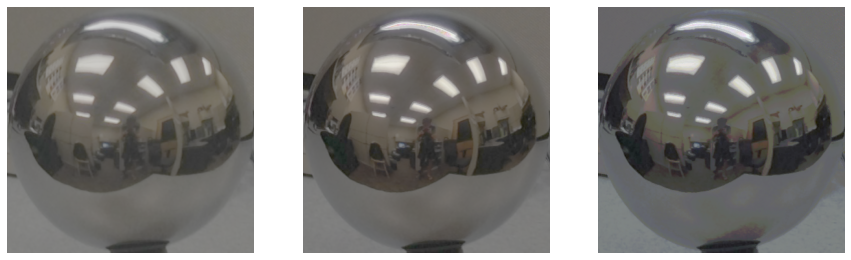

In [362]:
def weighted_log_error(ldr_images, hdr_image, log_irradiances):
  # computes weighted RMS error of log irradiances for each image compared to final log irradiance
  N, H, W, C = ldr_images.shape
  w = 1-abs(ldr_images - 0.5)*2
  err = 0
  for n in np.arange(N):
    err += np.sqrt(np.multiply(w[n], (log_irradiances[n]-np.log(hdr_image))**2).sum()/w[n].sum())/N 
  return err


# compare solutions
err = weighted_log_error(ldr_images, naive_hdr_image, naive_log_irradiances)
print('naive:  \tlog range = ', round(np.log(naive_hdr_image).max() - np.log(naive_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, weighted_hdr_image, naive_log_irradiances)
print('weighted:\tlog range = ', round(np.log(weighted_hdr_image).max() - np.log(weighted_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, calib_hdr_image, calib_log_irradiances)
print('calibrated:\tlog range = ', round(np.log(calib_hdr_image).max() - np.log(calib_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))

# display log hdr images (code provided in utils.display)
display_images_linear_rescale(np.log(np.stack((naive_hdr_image/naive_hdr_image.mean(), weighted_hdr_image/weighted_hdr_image.mean(), calib_hdr_image/calib_hdr_image.mean()), axis=0)))

## Panoramic transformations 

Compute the equirectangular image from the mirrorball image

In [377]:
def panoramic_transform(hdr_image):
    '''
    Given HDR mirror ball image, 
    
    Expects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.
    
    Steps to implement:
    1) Compute N image of normal vectors of mirror ball
    2) Compute R image of reflection vectors of mirror ball
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.
    
    Steps 3 and 4 are implemented for you with get_equirectangular_image

    '''
    H, W, C = hdr_image.shape
    Z = H
    center = len(hdr_image[0])/2
    print(center)
    reflection_vector = np.zeros(hdr_image.shape)
    normal_vector = np.zeros(hdr_image.shape)
    assert H == W
    assert C == 3
    #Make sure coordinates are correct -> Z,X,Y directions relationships are accurate

    # TO DO: compute N and R
        
    #1) Compute N Image of Normal Vectors of mirror ball
    # R = V - 2 * dot(V,N) * N
    V = np.array([0,0,-1])
    for u in range(W):
        for v in range(H):
                #Compute Normal Vector
                Nx = (u - center)/(W/2)
                Ny = (v - center)/(H/2)
                
                Nz = 1 - (Nx**2) - (Ny**2)
                if Nz < 0:
                    R = np.array([0,0,0])
                    N = np.array([0,0,0])
                else:
                    Nz = (math.sqrt(Nz))
                    N = np.array([Nx,Ny,Nz])
                    #Computer Reflection Vector
                    R = V - 2 * np.dot(V,N) * N
                R = np.array(R)
                N = np.array(N)
                reflection_vector[v,u,:] = R
                normal_vector[v,u,:] = N
                
                
    #plt.imshow((reflection_vector + 1) / 2)
    plt.imshow((normal_vector + 1) / 2)
    
    
    #plt.imshow((N+1)/2)
    #plt.show()
    #plt.imshow((R+1)/2)
    #plt.show()

    equirectangular_image = get_equirectangular_image(reflection_vector, hdr_image)
    return equirectangular_image

190.5
1.0
0.0


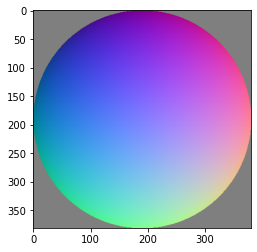

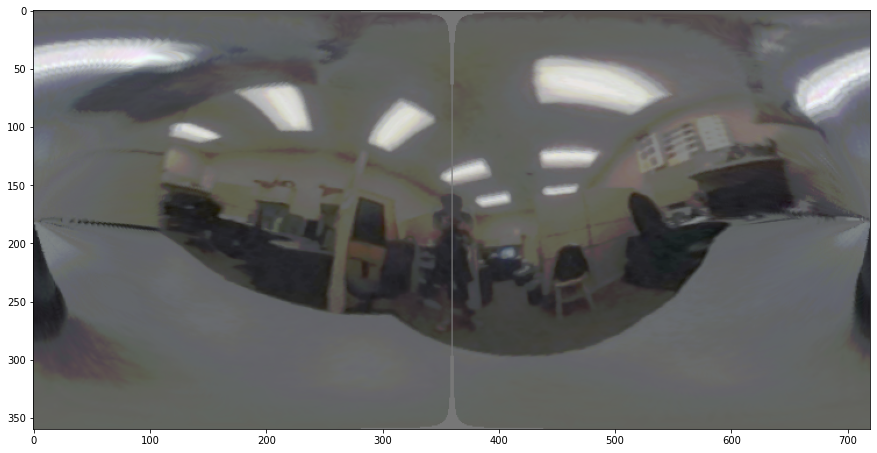

In [378]:
hdr_mirrorball_image = read_hdr_image('images/outputs/calib_hdr.hdr')
eq_image = panoramic_transform(hdr_mirrorball_image)

write_hdr_image(eq_image, 'images/outputs/equirectangular.hdr')

plt.figure(figsize=(15,15))
display_hdr_image(eq_image)


---

## Rendering synthetic objects into photographs 

Use Blender to render the scene with and with objects and obtain the mask image.  The code below should then load the images and create the final composite.

In [411]:

# Read the images that you produced using Blender.  Modify names as needed.
R = read_image('images/render4.png')
E = read_image('images/render4background.png')
M = read_image('images/render4mask.png')
M = M > 0.5
I = read_image('images/background87.jpg')
I = cv2.resize(I, (M.shape[1], M.shape[0]))
c = 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


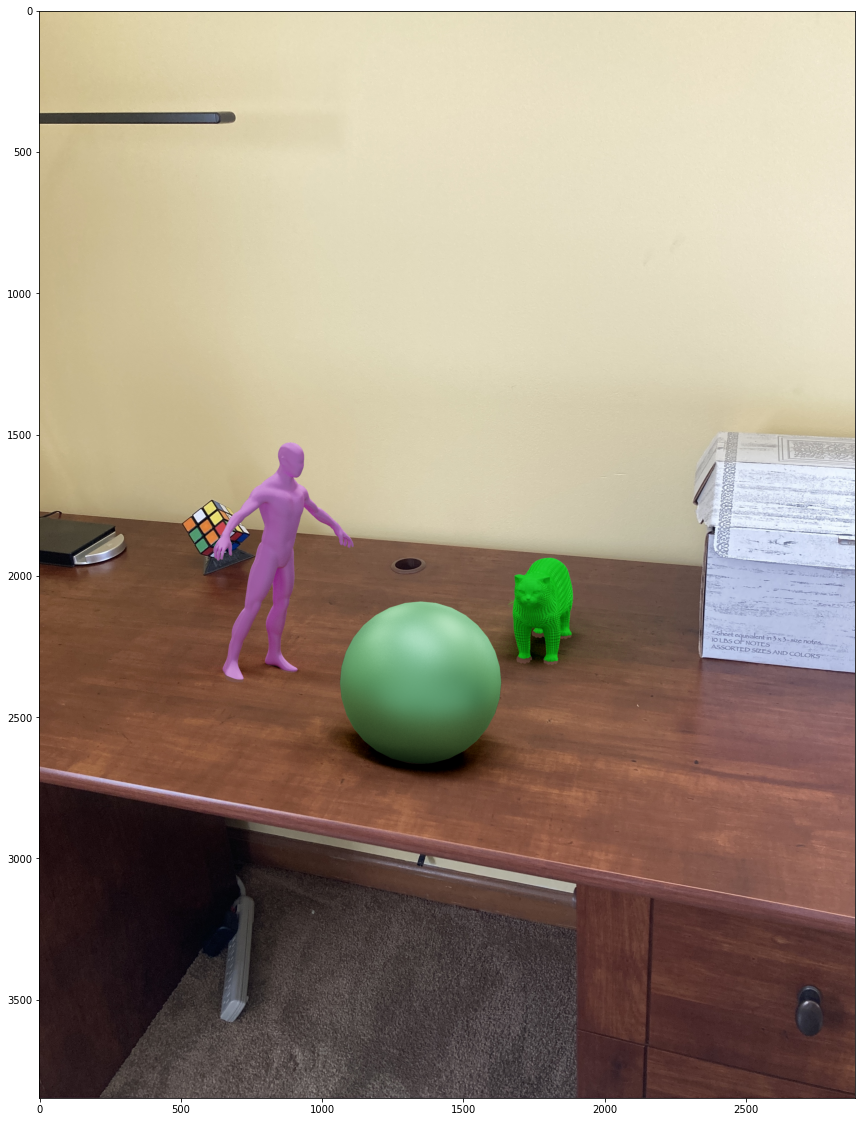

In [412]:
# TO DO: compute final composite
result = M*R+(1-M)*I+(1-M)*(R-E)*c 

plt.figure(figsize=(20,20))
plt.imshow(result)
plt.show()

write_image(result, 'images/outputs/final_composite.png')

---


## Bells & Whistles (Extra Points)

### Additional Image-Based Lighting Result 


### Other panoramic transformations 


### Photographer/tripod removal 


### Local tonemapping operator 



In [ ]:
#Additional Result provided in Report